In [1]:
import numpy as np
from skimage import io, data, transform
from scipy import sparse
from scipy import io as spio
import matplotlib.pyplot as plt
from img_utils import gamma_reconstruct
plt.gray()
%matplotlib inline
%load_ext autoreload
%autoreload 2

### Gamma prior
This method is similar to Tikhonov regularization in that we have a Gaussian prior on the derivative, but it differs in the fact that we do not directly specify the variance in that prior. Instead, we assume that the variances are distributed $\mathrm{gamma}(\alpha, \theta_0)$, where $\theta_0$ is the scale parameter and $\alpha$ is the shape parameter. We still assume the distribution of the derivatives are independent, so our covariance is a diagonal matrix $D_\theta$, where the $j$th diagonal entry is equal to $\theta_j$.
This gives us a prior over $\theta$ of
$$
    \Pr(\theta_j\mid \alpha, \theta_0) \propto \theta_j^{\alpha-1} \exp\left(-\frac{\theta_j}{\theta_0}\right)
$$
and a prior over $x$ of
\begin{align}
    \Pr(x) \propto \Pr(x\mid \theta)\Pr(\theta) & \propto \prod_{j=1}^n \theta_j^{-1/2} \exp\left(-\frac{1}{2}\lVert D_\theta^{-1/2} L_x x \rVert\right)\prod_{j=1}^n \theta_j^{-1/2} \exp\left(-\frac{1}{2}\lVert D_\theta^{-1/2} L_y x \rVert\right)\prod_{j=1}^n \Pr(\theta_j)\\
    &= \exp\left(-\frac{1}{2}\lVert D_\theta^{-1/2} L_x x \rVert-\frac{1}{2}\lVert D_\theta^{-1/2} L_y x \rVert\right)\prod_{j=1}^n \frac{\Pr(\theta_j)}{\theta_j}
\end{align}

Plugging this in and taking the negative log-likelihood, we get
$$
- \log L(x, \theta) \propto \frac{1}{\sigma_x^2}\left\lVert Ax-b \right\rVert^2 + \lVert D_\theta^{-1/2} L_x x \rVert+\lVert D_\theta^{-1/2} L_y x \rVert - (\alpha-2) \sum_{j=1}^n \log(\theta_j) + \sum_{j=1}^n \frac{\theta_j}{\theta_0}
$$

We can perform a two-step optimization procedure to minimize this quantity: First, we can minimize with respect to $x$ (with fixed $\theta$), and then fix $x$ and minimize over $\theta$. The $x$ minimization step requires a CGLS solve, which can be stopped when the residual goes below the level of white noise, which makes it quite fast. The $\theta$ minization step can be performed pointwise, so it is a negligible cost.

The exact $\theta$ update is as follows (let $\eta=\frac 12\left(\alpha-2\right)$):

$$
    \theta_k = \theta_0\left(\eta + \sqrt{\frac{(L_x x)_k^2+(L_y x)_k^2}{2\theta_0} + \eta^2} \right)
$$

/usr/local/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(-0.5, 255.5, 255.5, -0.5)

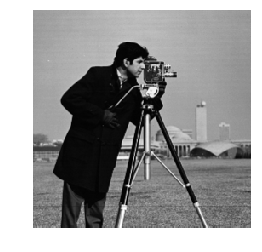

In [3]:
im = transform.resize(data.camera(), (256, 256))
plt.imshow(im)
plt.axis('off')

In [5]:
n = np.prod(im.shape)
sigma = 0.05
np.random.seed(1234)
indices = np.random.choice(
    np.prod(im.shape), size=(int(0.1 * np.prod(im.shape))), replace=False)
a = A = sparse.eye(np.prod(im.shape))
a = A = spio.loadmat('./convmat.mat')['A']
a = A = A.tocsr()[indices, :]
np.random.seed(4514142)
b = A @ im.reshape(-1) + np.random.randn(A.shape[0]) * sigma
m, n = A.shape

In [17]:
t = gamma_reconstruct(A, b, sigma, 1, 2.01)

Iteration 50 complete
Iteration 100 complete


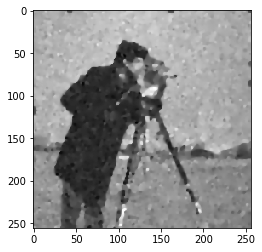

In [18]:
plt.imshow(t.reshape(*im.shape))